# <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2; text-align: center;">Sentiment Analysis</div>

It is widely known that, when conveying some kind of informative message, it is important to keep an objective tone, as the impact of the message on the target audience can greatly change depending on the tone of the message. This is why sentiment analysis is a very important tool when trying to find evidence of manipulation in messages created by disinformers.

Sentiment Analysis is a Natural Language Processing (NLP) technique used to determine the emotional tone behind a series of words, used to gain an understanding of the attitudes, opinions, and emotions expressed within a piece of text. In this notebook, this technique will be used to search for unneutral tones in the text of tweets, as well as to reaffirm the neutrality presence in the real tweets.

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Load dependencies</div>

In [1]:
import nltk
import pandas as pd
import html
import re
nltk.download('vader_lexicon', quiet=True)

from nltk.sentiment.vader import SentimentIntensityAnalyzer

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Apply data preprocessing</div>

Before starting to begin any Sentiment Analysis, some important preprocessing steps must be done in order to clean the data and maintain coherency in results with what has been done in the previous notebooks. The following steps were taken:

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;\">1. Data Loading</div>

First of all, the datasets inside the `data` folder must be loaded into the notebook. All train, test and validation datasets are fused into a single dataframe, which is stored inside the `tweets` variable.

In [2]:
DATA = 'data/'
test = pd.read_csv(DATA + 'Constraint_English_Test.csv', delimiter=';', encoding='utf-8')
train = pd.read_csv(DATA + 'Constraint_English_Train.csv', delimiter=';', encoding='utf-8')
val = pd.read_csv(DATA + 'Constraint_English_Val.csv', delimiter=';', encoding='utf-8')

tweets = pd.concat([train, val, test], ignore_index=True)
tweets.drop(columns=['id'], inplace=True)
tweets['tweet'] = tweets['tweet'].apply(html.unescape)

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;\">2. Data Cleaning</div>

Of course, the imported data is not perfect and must undergo some cleaning. The following steps were taken:

First of all, the duplicate instances were removed from the dataset. For this purpose, the `drop_duplicates` method was used, which removes all rows that are exactly the same as another row.
The `tweet` column was cleaned from any presence of URLs, and numbers (they are useless for topic modeling)
Some variables for storing real and fake tweets after processing were created.

Additionally, two variables were created to store the real and fake tweets after processing. The `real_tweets` variable stores the real tweets, while the `fake_tweets` variable stores the fake tweets.

In [3]:
processed_tweets = tweets.copy()
processed_tweets = processed_tweets.drop_duplicates(subset='tweet', keep='first')

# remove links
def filter(tweet:str):
    # https://stackoverflow.com/questions/3809401/what-is-a-good-regular-expression-to-match-a-url#3809435
    tweet = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', tweet)
    tweet = re.sub(r'\d+', '', tweet) # remove numbers, not useful for topic modeling
    tweet = re.sub(r'RT @[a-zA-Z0-9_]{1,15}:', '', tweet)
    return tweet

processed_tweets['tweet_nolinks'] = processed_tweets['tweet'].apply(filter)

# Recalculate indexes
processed_tweets['tweet'].reset_index(drop=True, inplace=True)
real_tweets = processed_tweets[processed_tweets['label'] == 'real']['tweet_nolinks']
fake_tweets = processed_tweets[processed_tweets['label'] == 'fake']['tweet_nolinks']

processed_tweets

,tweet,label,tweet_nolinks
0,The CDC currently reports 99031 deaths. In gen...,real,The CDC currently reports deaths. In general ...
1,States reported 1121 deaths a small rise from ...,real,States reported deaths a small rise from last...
2,Politically Correct Woman (Almost) Uses Pandem...,fake,Politically Correct Woman (Almost) Uses Pandem...
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real,#IndiaFightsCorona: We have #COVID testing la...
4,Populous states can generate large case counts...,real,Populous states can generate large case counts...
...,...,...,...
10695,#CoronaVirusUpdates: State-wise details of Tot...,real,#CoronaVirusUpdates: State-wise details of Tot...
10696,Tonight 12(midnight) onwards Disaster Manageme...,fake,Tonight (midnight) onwards Disaster Management...
10697,296 new cases of #COVID19Nigeria; Plateau-85 E...,real,new cases of #COVIDNigeria; Plateau- Enugu- O...
10698,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...,real,RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...


## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Apply sentiment extraction</div>

The next step (after all data is ready to be analyzed) is to apply the sentiment extraction. This process makes use of a pre-trained model that is able to detect and classify the sentiment of a given text, giving out three scores (one for Positive sentiment, one for Negative sentiment, and one for Neutral sentiment). The model used in this notebook is the `VADER` model, which is a model that is specifically designed for sentiment analysis of social media texts.

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;\">1. Model Initialization and preparation</div>

In [4]:
analyzer = SentimentIntensityAnalyzer()

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;\">2. Process the data with the model</div>

The next step is to analyze the sentiment of each real tweet and each fake tweet, and then store the results in the `real_sentiments` and `fake_sentiments` variables, respectively. The `VADER` model is used to analyze the sentiment of each tweet, and the results are stored in the `real_sentiments` and `fake_sentiments` variables.

In [5]:
real_sentiments = real_tweets.apply(lambda real_tweet: analyzer.polarity_scores(real_tweet))
fake_sentiments = fake_tweets.apply(lambda fake_tweet: analyzer.polarity_scores(fake_tweet))

real_tweet_sentiments = pd.DataFrame(real_sentiments.tolist())
fake_tweet_sentiments = pd.DataFrame(fake_sentiments.tolist())

real_tweet_sentiments.head()

,neg,neu,pos,compound
0,0.238,0.762,0.000,-0.8316
1,0.000,1.000,0.000,0.0000
2,0.000,1.000,0.000,0.0000
3,0.000,1.000,0.000,0.0000
4,0.000,0.936,0.064,0.3818


In [6]:
fake_tweet_sentiments.head()

,neg,neu,pos,compound
0,0.000,0.915,0.085,0.0772
1,0.593,0.407,0.000,-0.8074
2,0.000,0.752,0.248,0.5586
3,0.000,1.000,0.000,0.0000
4,0.080,0.828,0.092,-0.1531


## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Interpret results</div>

Once the sentiment analysis is done, the results must be interpreted. The following sections include a series of representations for each sentiment score, as well as a comparison between the sentiment scores of real and fake tweets.

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;\">1. Density Graph</div>

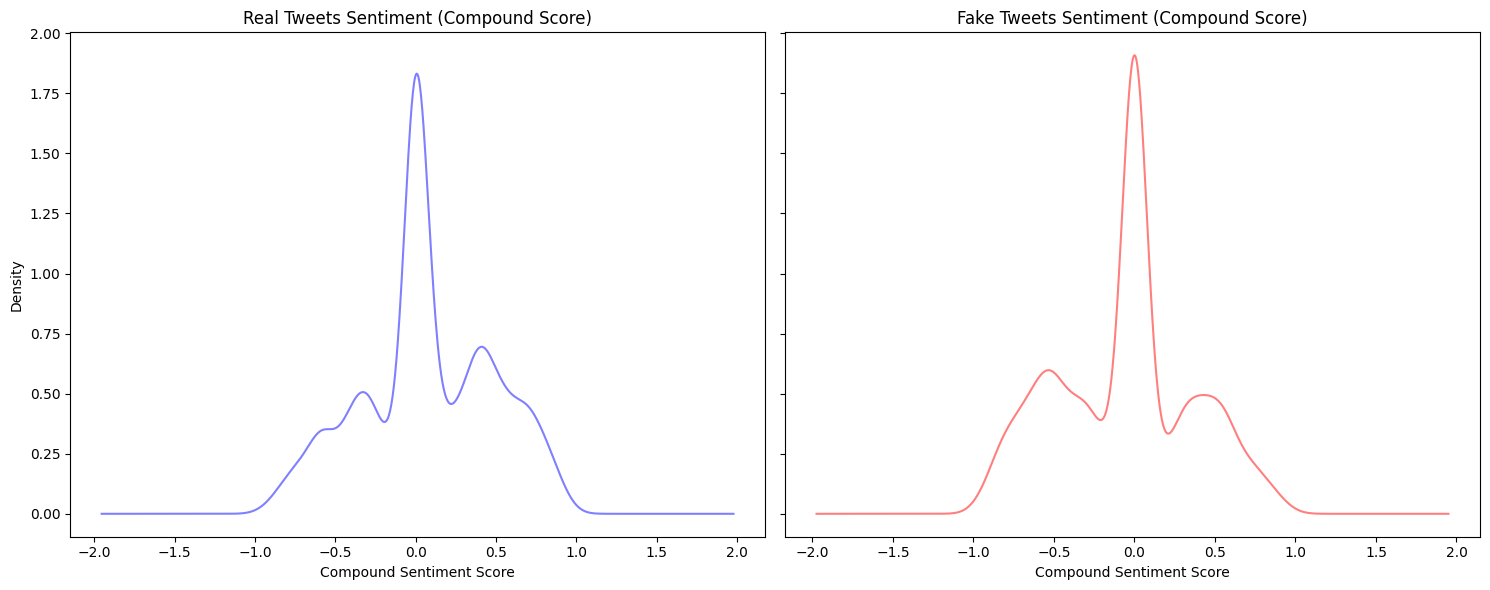

In [7]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

# Plot density graph for real tweet sentiments (compound score)
real_tweet_sentiments['compound'].plot.kde(ax=axes[0], color='blue', alpha=0.5)
axes[0].set_title('Real Tweets Sentiment (Compound Score)')
axes[0].set_xlabel('Compound Sentiment Score')
axes[0].set_ylabel('Density')

# Plot density graph for fake tweet sentiments (compound score)
fake_tweet_sentiments['compound'].plot.kde(ax=axes[1], color='red', alpha=0.5)
axes[1].set_title('Fake Tweets Sentiment (Compound Score)')
axes[1].set_xlabel('Compound Sentiment Score')

# Show plot
plt.tight_layout()
plt.show()

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;\">2. Histogram</div>

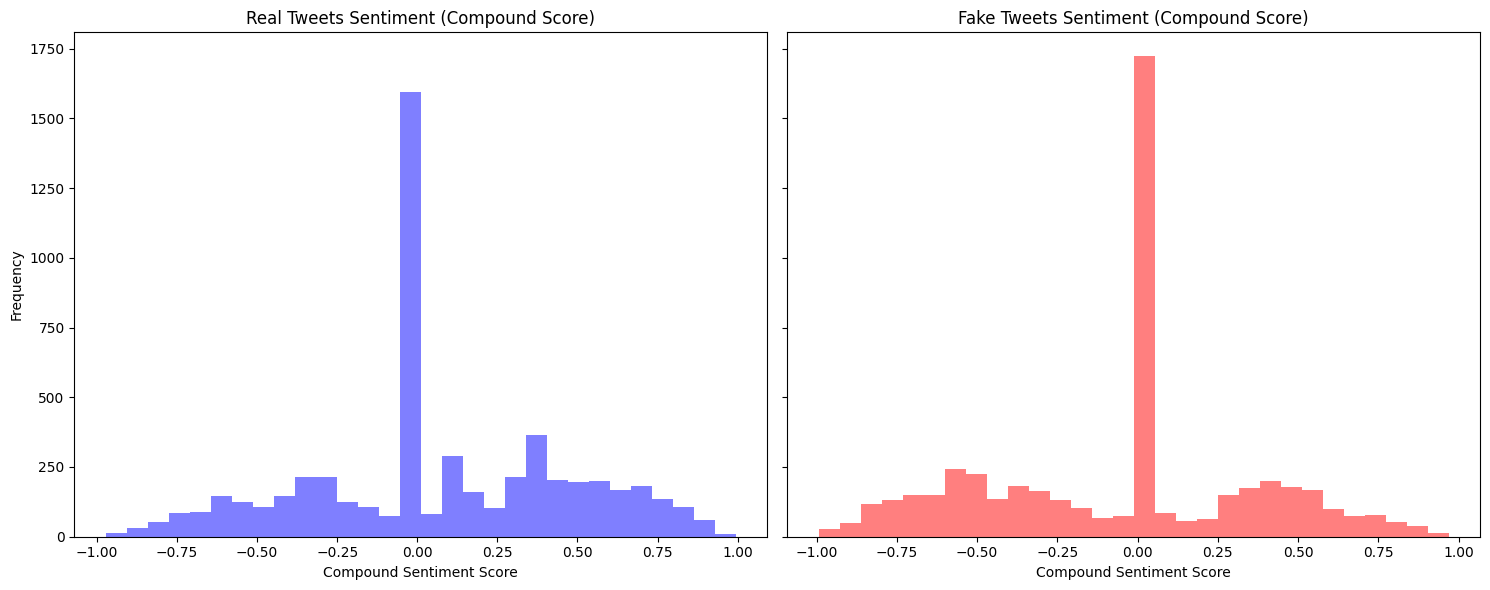

In [8]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

# Plot histogram for real tweet sentiments (compound score)
axes[0].hist(real_tweet_sentiments['compound'], bins=30, color='blue', alpha=0.5)
axes[0].set_title('Real Tweets Sentiment (Compound Score)')
axes[0].set_xlabel('Compound Sentiment Score')
axes[0].set_ylabel('Frequency')

# Plot histogram for fake tweet sentiments (compound score)
axes[1].hist(fake_tweet_sentiments['compound'], bins=30, color='red', alpha=0.5)
axes[1].set_title('Fake Tweets Sentiment (Compound Score)')
axes[1].set_xlabel('Compound Sentiment Score')

# Show plot
plt.tight_layout()
plt.show()

From what is seen in the graphs, it is possible to infer that there is no significant difference between the sentiment scores of real and fake tweets. This makes harder to detect fake tweets, since both real and fake instances have similar sentiment scores. Nevertheless, it is true that a minor difference in the non-neutral sentiment scores can be seen, with real tweets having a slightly higher frequency of positive sentiment scores than fake tweets.

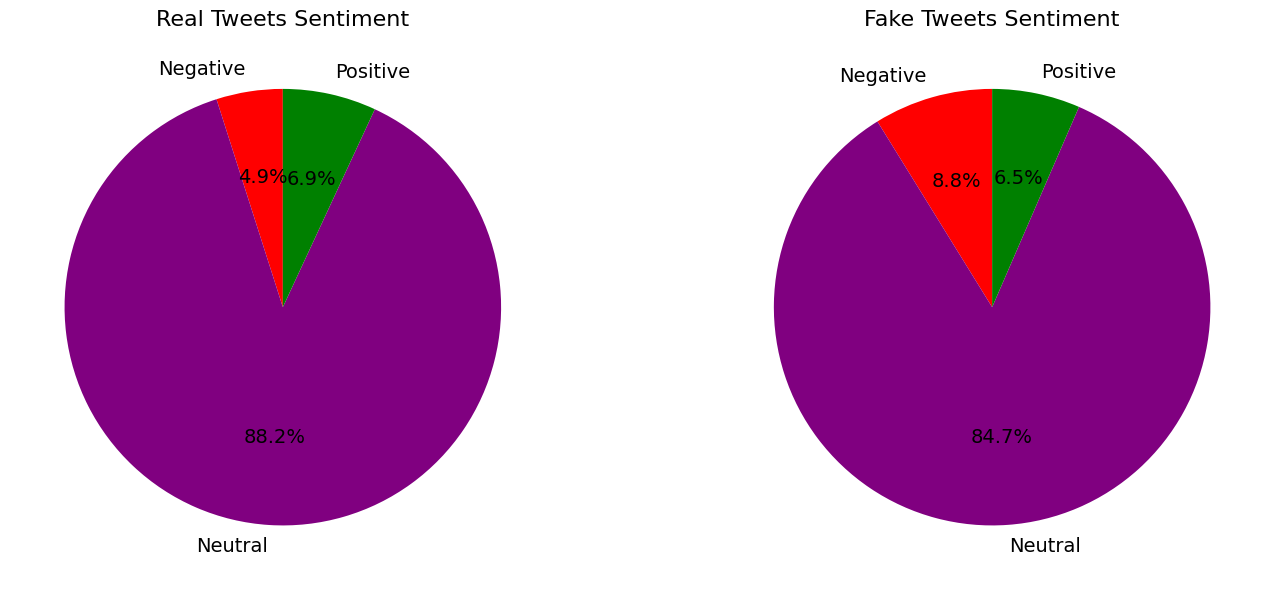

In [10]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

# Plot for real tweet sentiments 
axes[0].pie(real_tweet_sentiments[['neg', 'neu', 'pos']].mean(), labels=['Negative', 'Neutral', 'Positive'], autopct='%1.1f%%', colors=['red', 'purple', 'green'], startangle=90, textprops={'fontsize': 14})
axes[0].set_title('Real Tweets Sentiment', fontsize=16)

# Plot for fake tweet sentiments
axes[1].pie(abs(fake_tweet_sentiments[['neg', 'neu', 'pos']].mean()), labels=['Negative', 'Neutral', 'Positive'], autopct='%1.1f%%', colors=['red', 'purple', 'green'], startangle=90, textprops={'fontsize': 14})
axes[1].set_title('Fake Tweets Sentiment', fontsize=16)

# Show plot
plt.tight_layout()
plt.show()

Fake tweets tend to have a higher frequency of negative sentiment scores than real tweets. No other significant differences were found between the sentiment scores of real and fake tweets.